In [47]:
import torch
import numpy as np 
import pandas as pd 
from transformers import AutoTokenizer, AutoModelForMaskedLM
import tokenizers 
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from nltk.corpus import stopwords
import snowballstemmer 
from sklearn.svm import SVC
import numpy
import os 
import re
import pickle 
import matplotlib.pyplot as plt 
import seaborn as sns

In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
# loading model from huggingface
model = AutoModelForMaskedLM.from_pretrained("Shushant/nepaliBERT", output_hidden_states = True, return_dict = True, output_attentions = True)
tokenizers = AutoTokenizer.from_pretrained("Shushant/nepaliBERT")

In [3]:
print(tokenizers.tokenize("के मौजुदा लोकतान्त्रिक व्यवस्था राज्य पुनःसंरचनासँग जोडिएका हिजोका सवालहरूलाई यथास्थितिमा छोडेर सबल होला?"))

['क', 'मौ', '##ज', '##दा', 'लोक', '##तान', '##तर', '##िक', 'वय', '##वस', '##था', 'राज', '##य', 'पन', '##ः', '##सर', '##चना', '##सग', 'जोडिएका', 'हिजोका', 'सवाल', '##हर', '##लाई', 'यथा', '##स', '##थिति', '##मा', 'छोड', '##र', 'सबल', 'होला', '?']


In [4]:
nepali_stemmer = snowballstemmer.NepaliStemmer()

In [5]:
def bert_text_preparation(text, tokenizer ):
    """Preparing input for BERT"""
    
    marked_text = " [CLS] " + text + " [SEP] "
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(indexed_tokens) 
    
    # Convert inputs to Pytorch tensors
    tokens_tensors = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    
    return tokenized_text, tokens_tensors, segments_tensors

In [6]:
def get_bert_embeddings(tokens_tensor, segments_tensors, model):
    # Gradient claculation id disabled 
    # Model is in inference mode
    
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        # removing the first hidden state
        # the first state is the input state 
        hidden_states = outputs.hidden_states
    
    # Getting embeddings from final Bert Layer
    tokens_embeddings = hidden_states[-1]
    # Collasping the tensor into 1-dimension 
    tokens_embeddings = torch.squeeze(tokens_embeddings, dim = 0)
    # Converting torchtensors to lists 
    list_token_embeddings = [token_embed.tolist() for token_embed in tokens_embeddings]
    
    return list_token_embeddings 

In [7]:
# loading labelled dataset
df = pd.read_csv('dataset/collected_labeled_data.csv')

In [8]:
df['label'].unique()

array([2, 1, 0])

In [9]:
df.head(10)

,text,label
0,बजार ले जसरी ट्रेन्ड चेन्ज गर्यो यो हेर्दा तत्...,2
1,1000 अंकले घटेको नेप्से 200 अंकले बढ्नु ठूलो क...,1
2,होइन यो सानिमा बैंक ले bonus घोसणा गरेको २ महि...,2
3,"खैँ MBJC प्रति कित्तामा रू,10/-ले बढेर आज रू,1...",2
4,राम्रो भयो️️,1
5,"मध्यभोटेकोशिको शेयर ,, कर्मचारी संञ्चयकोष का स...",2
6,जानकारीको लागि धन्यवाद रामहरी ब्रदर,1
7,हाईड्रो र फाइनान्स बुम बुम भन्न छोडिएछ त ?,2
8,Profit booking ले यत्रो अङ्कको गिरावट त नआउनु ...,2
9,फेरि भर्चुअल मिटिङ कहिले हुन्छ दाजु हजुर जानका...,2


In [10]:
stopwords = stopwords.words("nepali")

In [14]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f" # dingbats
        u"\u3030"
    "]+", re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

In [15]:
def clean_text(text):
    text = remove_emojis(text)
    text = text.split(' ')
    clean_text_list = []
    for word in text:
        if word not in stopwords:
            clean_text_list.append(word)
    clean_text = ' '.join(clean_text_list)
    stem_words = nepali_stemmer.stemWords(clean_text.split())
#     stem_text = ' '.join(stem_words)
#     txt = re.sub(r"[|a-zA-z.'#0-9@,:?'\u200b\u200c\u200d!/&~-]",'',stem_text)
    return ' '.join([i for i in stem_words])

In [16]:
clean_text("घाम जति लग्यो हामीलाई तेती राम्रो हुन्छ apple ")
nepali_stemmer.stemWords("घाम जति लग्यो हामीलाई तेती राम्रो हुन्छ apple ".split())

['घाम', 'जति', 'लग्', 'हामी', 'तेती', 'राम्रो', '', 'apple']

In [17]:
# preprocessing to text column
df['text'] = df['text'].apply(clean_text)

In [18]:
df.head()

,text,label
0,बजार जसरी ट्रेन्ड चेन्ज गर् हेर् प्रोफिट बूकिङ...,2
1,1000 अंक घट नेप्से 200 अंक बढ् ठूलो कुरो होइन ...,1
2,होइन सानि बैंक bonus घोसणा २ महिना (book clos...,2
3,"खैँ MBJC कित्ता रू,10/- बढेर आज रू,1100/- 10क...",2
4,,1


In [19]:
def get_bert_embedding_sentence(input_sentence):
    '''function to generate nepali bert embedding'''
    md = model
    tokenizer = tokenizers
    marked_text = " [CLS] " + input_sentence + " [SEP] "
    tokenized_text = tokenizer.tokenize(marked_text)

    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(indexed_tokens) 
    
    # Convert inputs to Pytorch tensors
    tokens_tensors = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    
    with torch.no_grad():
        outputs = md(tokens_tensors, segments_tensors)
        # removing the first hidden state
        # the first state is the input state 

        hidden_states = outputs.hidden_states

    token_vecs = hidden_states[-2][0]

    # Calculate the average of all 22 token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=0)
    return sentence_embedding.numpy()

In [20]:
# dropping Neutral dataset having label=2
df=df.drop(df[df['label']==2].index)
df.dropna(inplace = True)

In [22]:
# generating word embeddings 
df['word_embeddings'] = df['text'].apply(get_bert_embedding_sentence)

In [23]:
df.shape

(6056, 3)

In [24]:
df.head()

,text,label,word_embeddings
1,1000 अंक घट नेप्से 200 अंक बढ् ठूलो कुरो होइन ...,1,"[-0.25172073, 0.804477, -0.30090094, 0.3639347..."
4,,1,"[0.08050504, -0.07306882, 0.003423947, 0.02479..."
6,जानकारी धन्यवाद रामहरी ब्रदर,1,"[0.2404593, 0.726399, -0.111936614, 0.14629368..."
18,"भारत-मधेस नेपाल-चीन सम्बन्ध विग्रन्छ, मधेसी ने...",0,"[0.15390028, 0.67477095, -0.15437016, -0.21242..."
25,"लेखनाथ न्यौपा खुलासा,महाधिबेशन एमसीसी गर् जुत्...",0,"[-0.077389546, 1.0393127, -0.10719734, -0.0086..."


In [25]:
# splitting input and targer dataset
X,y = df['word_embeddings'], df['label']

In [26]:
# data splitting
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size = 0.2, random_state = 420)

In [27]:
svc = SVC()

In [28]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': [1, 0.1, 0.01, 0.001]
}

In [29]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(train_X.tolist(), train_y)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [30]:
best_model

SVC(C=10, gamma=0.01)

In [31]:
svc_pred = best_model.predict(test_X.tolist())

In [41]:
cm = confusion_matrix(test_y, svc_pred)
print(cm)

[[428  87]
 [ 79 618]]


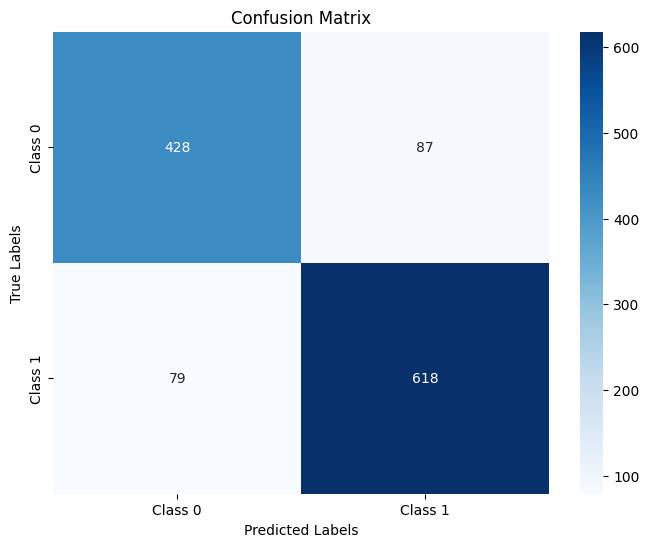

In [48]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [49]:
print(classification_report(test_y, svc_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84       515
           1       0.88      0.89      0.88       697

    accuracy                           0.86      1212
   macro avg       0.86      0.86      0.86      1212
weighted avg       0.86      0.86      0.86      1212



In [42]:
f1_score(test_y, svc_pred)

0.8790896159317211

In [43]:
sent = "नराम्रो"
predicted_label = svc.predict(np.array(get_bert_embedding_sentence(sent).tolist()).reshape(1,-1))[0]
if predicted_label == 0:
    print(f'{sent} is negative sentiment')
else:
    print(f'{sent} is positive sentiment')

नराम्रो is negative sentiment


In [38]:
# saving the model in pickle format
pickle.dump(best_model,open('trained_model/scv_sentiment','wb'))

In [50]:
# model loading
svc_sentiment = pickle.load(open('trained_model/scv_sentiment','rb'))

In [51]:
# testing
svc.predict(np.array(get_bert_embedding_sentence("देश बिग्रियो").tolist()).reshape(1,-1))[0]

0